In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sp
import pandas as pd

import re
import librosa

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import librosa.display
import IPython.display as ipd
import os

%matplotlib notebook

In [2]:
def cutter(x, sr=None):
    '''
    cutter(x) takes wave amplitude array (x) and trims the edges, to avoid vocal onsets/stops at the beginning/end.  
    '''
    if sr == None:
        n1 = int(0.25*len(x))
        n2 = int(0.75*len(x))
    
        return x[n1:n2] 
    
    else:
        mid_idx = int(len(x)//2) # middle index
        hlf_wdw = int(0.5*(sr)/2.0) # half of 30 sec window in # of elements 
        return x[mid_idx-hlf_wdw:mid_idx+hlf_wdw] 

def formant_signal(x,order):
    '''
    formant_signal(x,order) takes wave amplitude array (x) and returns the LPC approximation 
    (s_formant) based on a linear autoregressive model to a given specified order (order).
    
    s_formant can be understood as the (sourceless) amplitude due to the vocal formants of the signal x.
    '''
    
    a = librosa.lpc(x, order) # (x,16)
    b = np.hstack([[0], -1 * a[1:]])
    s_formant = sp.signal.lfilter(b, [1], x)
    
    return s_formant

def residual(x,order,s=None):
    '''
    residual(x,order,s) subtracts the formants from the input signal x to yield the source wave (vocal cord buzz).
    '''
    if s is None: 
        s_formant = formant_signal(x,order)
        return (x-s_formant)
    else:
        return (x-s)

def audio_processor(x,sr=44100,order=16):
    '''
    Take input file and return ready for CNN 
    '''
    #x, sr = librosa.load(path_raw+file_test,sr=44100) #
    R_ = librosa.stft(residual(cutter(x,sr),order),n_fft=2048) # complex matrix 
    Rabs_ = np.abs(R_)
    RdB_ = librosa.amplitude_to_db(Rabs_, ref=np.max)
    RdB_expanded = np.expand_dims(RdB_, axis=2)
    RdB_ready = np.array( [RdB_expanded,] )
    #predict_2 = model.predict(   )
    
    return RdB_ready

def get_wave_array(path):
    
    filelist = [x for x in os.listdir(path) if not x.startswith('.')]
    filelist.sort(key=lambda f: int(re.sub('\D', '', f)))
    
    wave_array = np.loadtxt(path+filelist[0])
    
    for index,file in enumerate(filelist[1:]):
        
        if int(re.sub('\D', '', file)) != (1+index):
            print('Error: index mismatch')
            
        wave_array = np.vstack((wave_array,np.loadtxt(path+file)))

    print(wave_array.shape)
    
    return wave_array

def get_y3(y):
    
    y3 = np.copy(y)
    
    for index,elem in enumerate(y):
        
        if int(elem) == 2:
            
            y3[index] = 1
            
        if int(elem) == 3:
            
            y3[index] = 2
            
    return y3

def make_image_array(cord_array,n_fft):
    
    c_wave_0 = cord_array[0,:]
    c_image_0 = cord_to_image(c_wave_0,n_fft)
    im_f,im_t = c_image_0.shape[0],c_image_0.shape[1]
    print(im_f,im_t)
    
    RdB_array = np.zeros((cord_array.shape[0],im_f,im_t))
    
    for index in range(cord_array.shape[0]):
        
        c_wave = cord_array[index,:]
        c_image = cord_to_image(c_wave,n_fft)
        
        RdB_array[index,:,:] = c_image
    
    print(RdB_array.shape)
    
    return RdB_array   

def cord_to_image(c_wave,n_fft=2048):
    
    R = librosa.stft(c_wave,n_fft=n_fft)
    Rabs = np.abs(R)
    RdB = librosa.amplitude_to_db(Rabs, ref=np.max)
    
    return RdB

In [3]:
# Specify Data Paths
path_raw =  os.path.abspath(os.pardir+"/Data/Data_Raw_Labeled/") + "/"
path_wave =  os.path.abspath(os.pardir+"/Data/Data_Wave/") + "/"
path_cord =  os.path.abspath(os.pardir+"/Data/Data_Cord/") + "/"
path_lab =  os.path.abspath(os.pardir+"/Data/Data_Lab/") + "/"
path_input =  os.path.abspath(os.pardir+"/Data/Data_Input/") + "/"
path_train =  os.path.abspath(os.pardir+"/Data/Data_Train/") + "/"
path_test =  os.path.abspath(os.pardir+"/Data/Data_Test/") + "/"
path_mic_f =  os.path.abspath(os.pardir+"/Mic_FR/freqs") + "/"
path_mic_a =  os.path.abspath(os.pardir+"/Mic_FR/amps") + "/"
path_mic =  os.path.abspath(os.pardir+"/Mic_FR/") + "/"

path_mic

'/Users/tamiro/Desktop/Insight/Code/SafeSing/SafeSing_Project/Mic_FR/'

In [61]:
# filelist = [x for x in os.listdir(path_cord) if not x.startswith('.')]
# filelist.sort(key=lambda f: int(re.sub('\D', '', f))) #-/
# filelist

# print(get_wave_array(path_wave)) #-/

In [7]:
# Specify the Order of the Formant Approximation
order = 16

# Organize & Process Audio

In [14]:
# Process waves from Data_Raw_Labeled into abs(amplitude) images, dump into path_mat
# labels B: Breathy , N: Neutral, F: Flow, P: Pressed

save = False # set to True to save output

# counters
cb = 0 # count breathy
cn = 0 # count neutral
cf = 0 # count flow
cp = 0 # count pressed

# get all files in the path_raw folder
filelist = [x for x in os.listdir(path_raw) if not x.startswith('.')]

# initialize labels (y) array - one label for every input file.
y = np.zeros(len(filelist),dtype=int)

for index, file in enumerate(filelist[:]):
    
    print('index=',index)
    
    if 'breathy' in file:
        label = 0 
        cb += 1
    if 'neutral' in file:
        label = 1 
        cn += 1
    if 'flow' in file:
        label = 2 
        cf += 1
    if 'pressed' in file:
        label = 3 
        cp += 1
    try:
        x, sr = librosa.load(path_raw+file,sr=44100) #
        if len(x) < 22050: # if less than half a second
            print('WARNING, INPUT LESS THAN 30 SECS!')
        #print(x.shape)
    except:
        print(file+'has an issue')
    
    trim = cutter(x,sr)
    cord = residual(trim,order)
    y[index] = label
    
    if save==True:
        np.savetxt(path_wave+'W'+str(index)+'.txt',trim)
        np.savetxt(path_cord+'C'+str(index)+'.txt',cord)

if save==True:
    np.savetxt(path_lab+'y_tune'+'.txt',y)
    
print('counts:',cb,cn,cf,cp)
print('len_file_list:'+str(len(filelist))+' =? '+str(cb+cn+cf+cp))

index= 0
index= 1
index= 2
index= 3
index= 4
index= 5
index= 6
index= 7
index= 8
index= 9
index= 10
index= 11
index= 12
index= 13
index= 14
index= 15
index= 16
index= 17
index= 18
index= 19
index= 20
index= 21
index= 22
index= 23
index= 24
index= 25
index= 26
index= 27
index= 28
index= 29
index= 30
index= 31
index= 32
index= 33
index= 34
index= 35
index= 36
index= 37
index= 38
index= 39
index= 40
index= 41
index= 42
index= 43
index= 44
index= 45
index= 46
index= 47
index= 48
index= 49
index= 50
index= 51
index= 52
index= 53
index= 54
index= 55
index= 56
index= 57
index= 58
index= 59
index= 60
index= 61
index= 62
index= 63
index= 64
index= 65
index= 66
index= 67
index= 68
index= 69
index= 70
index= 71
index= 72
index= 73
index= 74
index= 75
index= 76
index= 77
index= 78
index= 79
index= 80
index= 81
index= 82
index= 83
index= 84
index= 85
index= 86
index= 87
index= 88
index= 89
index= 90
index= 91
index= 92
index= 93
index= 94
index= 95
index= 96
index= 97
index= 98
index= 99
index= 100

index= 755
index= 756
index= 757
index= 758
index= 759
index= 760
index= 761
index= 762
index= 763
index= 764
index= 765
index= 766
index= 767
index= 768
index= 769
index= 770
index= 771
index= 772
index= 773
index= 774
index= 775
index= 776
index= 777
index= 778
index= 779
index= 780
index= 781
index= 782
index= 783
index= 784
index= 785
index= 786
index= 787
index= 788
index= 789
index= 790
index= 791
index= 792
index= 793
index= 794
index= 795
index= 796
index= 797
index= 798
index= 799
index= 800
index= 801
index= 802
index= 803
index= 804
index= 805
index= 806
index= 807
index= 808
index= 809
index= 810
index= 811
index= 812
index= 813
index= 814
index= 815
index= 816
index= 817
index= 818
index= 819
index= 820
index= 821
index= 822
index= 823
index= 824
index= 825
index= 826
index= 827
index= 828
index= 829
index= 830
index= 831
index= 832
index= 833
index= 834
index= 835
index= 836
index= 837
index= 838
index= 839
index= 840
index= 841
index= 842
index= 843
index= 844
index= 845

In [46]:
# LOAD
cord_array = get_wave_array(path_cord) 
y_tune = np.loadtxt(path_lab+'y_tune'+'.txt')

# Check y is the same as before (consistent).
# y_ = np.loadtxt(path_lab+'y'+'.txt')
# print(y==y_tune) -/

y_tune = (np.round(y_tune,1)).astype(int)
y3 = get_y3(y)

print(y3.shape,y3.dtype)

(909, 22050)
(909, 22050)
(909,)


(909,) int64


In [82]:
# test-train split (before augmentation)

# Train_Test_Split
train_cord, test_cord, train_labels, test_labels = train_test_split(cord_array, y3, test_size=0.2, random_state=2)


In [111]:
# SAVE/LOAD Train/Test Split
# np.savetxt(path_train+'cord'+'.txt',train_cord)
# np.savetxt(path_train+'lab'+'.txt',train_labels)
# np.savetxt(path_test+'cord'+'.txt',test_cord)
# np.savetxt(path_test+'lab'+'.txt',test_labels)

train_cord = np.loadtxt(path_train+'cord'+'.txt')
train_labels = np.loadtxt(path_train+'lab'+'.txt')
test_cord = np.loadtxt(path_test+'cord'+'.txt')
test_labels = np.loadtxt(path_test+'lab'+'.txt')


In [112]:
#Is the test set balanced
occurrences0 = list(test_labels).count(0)
occurrences1 = list(test_labels).count(1)
occurrences2 = list(test_labels).count(2)

print(occurrences0,occurrences1,occurrences2)

46 79 57


In [117]:
print(train_cord.shape[0])
print(test_cord.shape[0])

727
182


In [98]:

n_fft=2048
#make_image_array(train_cord[:10,:],n_fft) -/ 

In [303]:
def build_model_arch(im_f,im_t,num_filters=8,filter_size=3,pool_size=2):
    
    print('num_filters=',num_filters,'filter_size=',filter_size,'pool_size=',pool_size)
    # Build the model.
    model = Sequential([
      Conv2D(num_filters, filter_size, input_shape=(im_f, im_t, 1)), #Dense(num_filters, activation='relu'),
      MaxPooling2D(pool_size=pool_size),
      Flatten(),
      Dense(3, activation='softmax'),
    ])

    # Compile the model.
    model.compile(
      'adam',
      loss='categorical_crossentropy',
      metrics=['accuracy'],
    )
    
    return model

def build_model(train_cord,n_fft=2048,num_filters=8,filter_size=3,pool_size=2):
    
    c_wave_0 = train_cord[0,:]
    c_image_0 = cord_to_image(c_wave_0,n_fft)
    im_f,im_t = c_image_0.shape[0],c_image_0.shape[1]
       
    model = build_model_arch(im_f,im_t,num_filters=num_filters,filter_size=filter_size,pool_size=pool_size)
    return model

In [306]:
# Train Model

def train_model(train_cord, test_cord, train_labels, test_labels,n_fft=2048,num_filters=8,filter_size=3,pool_size=2):

    # make infrastructure
    model = build_model(train_cord,n_fft=2048,num_filters=num_filters,filter_size=filter_size,pool_size=pool_size)
    
    # pre-process the data: cord to image
    train_images = make_image_array(train_cord,n_fft)
    test_images = make_image_array(test_cord,n_fft)

    # Reshape the images.
    train_images = np.expand_dims(train_images, axis=3)
    test_images = np.expand_dims(test_images, axis=3)
    print(train_images.shape)
    print(test_images.shape)
    
    # Fit model
    model.fit(
      train_images,
      to_categorical(train_labels),
      epochs=16,
      validation_data=(test_images, to_categorical(test_labels)),
    ) 
    
    return model

In [122]:
model = train_model(train_cord, test_cord, train_labels, test_labels)

model.save_weights('ssing_cnn_v3.h5')

1025 44
(727, 1025, 44)
1025 44
(182, 1025, 44)
(727, 1025, 44, 1)
(182, 1025, 44, 1)
Epoch 1/25
23/23 [==============================] - 5s 233ms/step - loss: 886.4390 - accuracy: 0.3920 - val_loss: 460.2029 - val_accuracy: 0.4341
Epoch 2/25
23/23 [==============================] - 5s 206ms/step - loss: 239.4082 - accuracy: 0.4168 - val_loss: 131.4494 - val_accuracy: 0.5000
Epoch 3/25
23/23 [==============================] - 5s 209ms/step - loss: 84.3798 - accuracy: 0.5048 - val_loss: 18.6836 - val_accuracy: 0.5934
Epoch 4/25
23/23 [==============================] - 5s 212ms/step - loss: 10.9119 - accuracy: 0.7579 - val_loss: 14.3541 - val_accuracy: 0.6319
Epoch 5/25
23/23 [==============================] - 4s 194ms/step - loss: 5.3244 - accuracy: 0.8033 - val_loss: 10.5542 - val_accuracy: 0.6813
Epoch 6/25
23/23 [==============================] - 6s 272ms/step - loss: 4.7865 - accuracy: 0.8088 - val_loss: 8.8527 - val_accuracy: 0.7088
Epoch 7/25
23/23 [==============================]

# Augment data based on microphone response functions

In [125]:
# LOAD
wave_array = get_wave_array(path_wave) 
y_tune = np.loadtxt(path_lab+'y_tune'+'.txt')

# Check y is the same as before (consistent).
# y_ = np.loadtxt(path_lab+'y'+'.txt')
# print(y==y_tune) -/

y_tune = (np.round(y_tune,1)).astype(int)
y3 = get_y3(y)

print(y3.shape,y3.dtype)

(909, 22050)
(909,) int64


In [126]:
# test-train split (before augmentation)

# Train_Test_Split
train_wave, test_wave, train_labels, test_labels = train_test_split(wave_array, y3, test_size=0.2, random_state=2)


In [127]:
# SAVE/LOAD Train/Test Split
np.savetxt(path_train+'wave'+'.txt',train_wave)
np.savetxt(path_train+'w-lab'+'.txt',train_labels)
np.savetxt(path_test+'wave'+'.txt',test_wave)
np.savetxt(path_test+'w-lab'+'.txt',test_labels)

train_wave = np.loadtxt(path_train+'wave'+'.txt')
train_labels = np.loadtxt(path_train+'w-lab'+'.txt')
test_wave = np.loadtxt(path_test+'wave'+'.txt')
test_labels = np.loadtxt(path_test+'w-lab'+'.txt')


In [276]:
import random

r = list(range(train_wave.shape[0]))
random.shuffle(r)

train_wave_extension1 = []

print(train_wave.shape[0])
for j,index in enumerate(r[:200]):#np.arange(train_wave.shape[0])[:1]:
    print(j)
    sample = train_wave[index,:]
    #print(sample.shape)
    R = librosa.stft(sample,n_fft=n_fft)
    
    filelist = [x for x in os.listdir(path_mic) if x.startswith('filter_array')]
    
    for idx,file in enumerate(filelist):
        print(file)
        filter_array = np.loadtxt(path_mic+file)
    
        Fi=librosa.db_to_amplitude(filter_array) 
        F0=librosa.db_to_amplitude(10.0*np.ones((filter_array.shape[0],filter_array.shape[1]))) 
        Rnew = np.multiply(R, np.divide(Fi,F0)) #*(Fi/F0)

        wave_new = librosa.istft(Rnew,win_length=2048,length=22050) # REVISE
        #print(wave_new.shape)
        if (idx == 0) and (j==0):
            train_wave_extension1 = wave_new
            train_labels_extension1 = [train_labels[idx]]
        else:
            train_wave_extension1 = np.vstack((train_wave_extension1,wave_new))
            train_labels_extension1.append(train_labels[idx])
#cord_to_image(c_wave,n_fft): # out put RdB
print(train_wave_extension1)
print(train_labels_extension1)

727
0
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
1
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
2
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
3
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
4
filter_array_Neumann U87.txt
filter_ar

filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
35
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
36
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
37
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
38
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Co

filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
69
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
70
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
71
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
72
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_a

103
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
104
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
105
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
106
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
107
filter_array_Neumann U87.txt
fil

137
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
138
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
139
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
140
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
141
filter_array_Neumann U87.txt
fil

171
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
172
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
173
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
174
filter_array_Neumann U87.txt
filter_array_Shure SM-57.txt
filter_array_Electrovoice Re20.txt
filter_array_AKG 451.txt
filter_array_Coles 4038.txt
filter_array_Schoeps Omni.txt
filter_array_Sennheiser 441.txt
filter_array_Royer R-121.txt
175
filter_array_Neumann U87.txt
fil

In [278]:
print(train_wave_extension1.shape)
print(len(train_labels_extension1))

(1600, 22050)
1600


In [279]:
# np.savetxt(path_train+'wave_ext1.txt',train_wave_extension1)
# np.savetxt(path_train+'w-lab_ext1.txt',np.array(train_labels_extension1))

In [262]:
import IPython.display as ipd
ipd.Audio(sample, rate=44100) # load a NumPy array


In [263]:
ipd.Audio(wave_new, rate=44100) # load a NumPy array

In [151]:
freqs = np.arange(0, 1 + n_fft / 2) * sr / n_fft

In [196]:
# plt.figure(0)
# plt.plot(freqs)
freq_bins = freqs.shape
print(freq_bins)
time_bins = int(2*sr/n_fft + 1)
print(time_bins)

(1025,)
44


In [210]:
def nan_helper(ys):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(ys), lambda z: z.nonzero()[0]

In [253]:
# get all files in the path_mic folder
def make_filter_arrays():
    #plt.figure(4)
    
    filelist = [x for x in os.listdir(path_mic_f) if not x.startswith('.')]

    filter_array = np.zeros((freq_bins[0],time_bins))

    for index, file in enumerate(filelist[:]):

        core_file = file[:-5]
        print('filename=',core_file)
        a =np.loadtxt(path_mic_a+core_file+'a.txt')
        f =np.loadtxt(path_mic_f+core_file+'f.txt')

        bin_indices = np.digitize(f,freqs,right=True)
        #print(bin_indices)
        f_means = np.array([f[bin_indices == i].mean() for i in range(0, freq_bins[0])])  
        a_means =  np.array([a[bin_indices == i].mean() for i in range(0, freq_bins[0])])

        nans, x= nan_helper(f_means)
        f_means[nans]= np.interp(x(nans), x(~nans), f_means[~nans])
        
        nans, a= nan_helper(a_means)
        a_means[nans]= np.interp(a(nans), a(~nans), a_means[~nans])

        #plt.plot(f_means,(1./90)*a_means)
        #plt.semilogx()
        for j in range(filter_array.shape[1]):
            filter_array[:,j] = (1.0/9)*a_means[:]

        np.savetxt(path_mic+'filter_array_'+str(file[:-6])+'.txt',filter_array)
        print(filter_array)


In [254]:
make_filter_arrays()

filename= Coles 4038_
[[5.70738753 5.70738753 5.70738753 ... 5.70738753 5.70738753 5.70738753]
 [5.70738753 5.70738753 5.70738753 ... 5.70738753 5.70738753 5.70738753]
 [9.34443519 9.34443519 9.34443519 ... 9.34443519 9.34443519 9.34443519]
 ...
 [8.56811111 8.56811111 8.56811111 ... 8.56811111 8.56811111 8.56811111]
 [8.56811111 8.56811111 8.56811111 ... 8.56811111 8.56811111 8.56811111]
 [8.56811111 8.56811111 8.56811111 ... 8.56811111 8.56811111 8.56811111]]
filename= Neumann U87_
[[5.53081843 5.53081843 5.53081843 ... 5.53081843 5.53081843 5.53081843]
 [5.53081843 5.53081843 5.53081843 ... 5.53081843 5.53081843 5.53081843]
 [8.30625926 8.30625926 8.30625926 ... 8.30625926 8.30625926 8.30625926]
 ...
 [7.754      7.754      7.754      ... 7.754      7.754      7.754     ]
 [7.754      7.754      7.754      ... 7.754      7.754      7.754     ]
 [7.754      7.754      7.754      ... 7.754      7.754      7.754     ]]
filename= Sennheiser 441_
[[2.0552439  2.0552439  2.0552439  ... 2.

<ipython-input-253-07d9cecc0b6c>:18: RuntimeWarning: Mean of empty slice.
  f_means = np.array([f[bin_indices == i].mean() for i in range(0, freq_bins[0])])
<ipython-input-253-07d9cecc0b6c>:19: RuntimeWarning: Mean of empty slice.
  a_means =  np.array([a[bin_indices == i].mean() for i in range(0, freq_bins[0])])


[[5.79189702 5.79189702 5.79189702 ... 5.79189702 5.79189702 5.79189702]
 [5.79189702 5.79189702 5.79189702 ... 5.79189702 5.79189702 5.79189702]
 [8.34333333 8.34333333 8.34333333 ... 8.34333333 8.34333333 8.34333333]
 ...
 [8.31688889 8.31688889 8.31688889 ... 8.31688889 8.31688889 8.31688889]
 [8.31688889 8.31688889 8.31688889 ... 8.31688889 8.31688889 8.31688889]
 [8.31688889 8.31688889 8.31688889 ... 8.31688889 8.31688889 8.31688889]]
filename= AKG 451_
[[4.20077507 4.20077507 4.20077507 ... 4.20077507 4.20077507 4.20077507]
 [4.20077507 4.20077507 4.20077507 ... 4.20077507 4.20077507 4.20077507]
 [8.07637963 8.07637963 8.07637963 ... 8.07637963 8.07637963 8.07637963]
 ...
 [9.272      9.272      9.272      ... 9.272      9.272      9.272     ]
 [9.272      9.272      9.272      ... 9.272      9.272      9.272     ]
 [9.272      9.272      9.272      ... 9.272      9.272      9.272     ]]
filename= Shure SM-57_
[[3.73502981 3.73502981 3.73502981 ... 3.73502981 3.73502981 3.7350298

In [281]:
train_wave_aug = np.vstack((train_wave,train_wave_extension1))
train_labels_aug =np.concatenate((train_labels,train_labels_extension1)) 

print(train_wave_aug.shape)
print(train_labels_aug.shape)

(2327, 22050)
(2327,)


In [282]:
def wave_to_cord(wave_array):
    
    for i in range(0,wave_array.shape[0]):
        trim = cutter(wave_array[i,:],sr=44100)
        if i == 0:
            
            cord_array = residual(trim,order)
        else:
            cord_array = np.vstack((cord_array,residual(trim,order)))
            
    return cord_array

In [284]:
train_cord_aug = wave_to_cord(train_wave_aug)

In [285]:
train_cord_aug.shape

(2327, 22050)

In [307]:
model = train_model(train_cord_aug, test_cord, train_labels_aug, test_labels,num_filters=12,filter_size=3,pool_size=2)

model.save_weights('ssing_cnn_v6.h5')

num_filters= 12 filter_size= 3 pool_size= 2
1025 44
(2327, 1025, 44)
1025 44
(182, 1025, 44)
(2327, 1025, 44, 1)
(182, 1025, 44, 1)
Epoch 1/16
73/73 [==============================] - 18s 246ms/step - loss: 187.0112 - accuracy: 0.4027 - val_loss: 8.7014 - val_accuracy: 0.5165
Epoch 2/16
73/73 [==============================] - 20s 271ms/step - loss: 15.1224 - accuracy: 0.4886 - val_loss: 7.2544 - val_accuracy: 0.5275
Epoch 3/16
73/73 [==============================] - 20s 275ms/step - loss: 16.1014 - accuracy: 0.4998 - val_loss: 9.3267 - val_accuracy: 0.4341
Epoch 4/16
73/73 [==============================] - 19s 260ms/step - loss: 13.2265 - accuracy: 0.5144 - val_loss: 4.4974 - val_accuracy: 0.6264
Epoch 5/16
73/73 [==============================] - 23s 311ms/step - loss: 12.0507 - accuracy: 0.5376 - val_loss: 7.4706 - val_accuracy: 0.5769
Epoch 6/16
73/73 [==============================] - 18s 252ms/step - loss: 11.8419 - accuracy: 0.5526 - val_loss: 6.2765 - val_accuracy: 0.5055
Epo

In [287]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [316]:
model = build_model(train_cord,n_fft=2048,num_filters=8)
    
model.load_weights('ssing_cnn_v3.h5')

test_images = make_image_array(test_cord,n_fft)
test_images = np.expand_dims(test_images, axis=3)

predictions = model.predict(test_images[:])
cm =confusion_matrix(test_labels, np.argmax(predictions, axis=1))

num_filters= 8 filter_size= 3 pool_size= 2
1025 44
(182, 1025, 44)


<IPython.core.display.Javascript object>


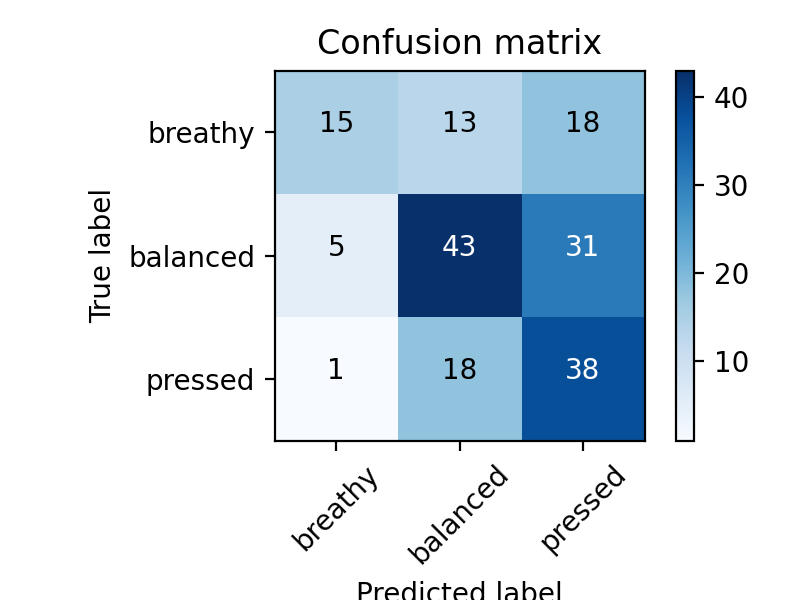

In [317]:
plot_confusion_matrix(cm,['breathy','balanced','pressed'],
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

In [292]:
# diagnosing imbalance
tp = 38+15+18+1 
fp = 5+31
fn = 13+18
precision = tp/(tp+fp)
recall = tp/(tp+fn)

print(precision,recall)

0.6666666666666666 0.6990291262135923


In [294]:
print('F:',2*(precision*recall)/(precision+recall))

F: 0.6824644549763034
